<a href="https://colab.research.google.com/github/Rajibsigdel12345/Vehicle-Detection/blob/main/Vehicle-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless ultralytics easyocr

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import easyocr

In [ ]:
def lane_detection_image(image_path):

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blur_gray = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blur_gray, 50, 150)

    height, width = image.shape[:2]
    vertices = np.array([[(50, height), (width//2 - 30, height//2 + 50),
                          (width//2 + 30, height//2 + 50), (width-50, height)]], dtype=np.int32)
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, 255)
    masked_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180, threshold=15, minLineLength=40, maxLineGap=20)

    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

    combined = cv2.addWeighted(image, 0.8, line_image, 1, 0)

    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


In [ ]:

# Function to detect edges
def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

# Function to define region of interest (ROI)
def region_of_interest(edges, vertices):
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, 255)
    masked_edges = cv2.bitwise_and(edges, mask)
    return masked_edges

# Function to draw lane lines
def draw_lines(image, lines):
    if lines is None or len(lines) == 0:
        return image  # Return the original image if no lines are provided

    for line in lines:
        # Handle cases where lines are stored as nested or flat structures
        if isinstance(line, (list, np.ndarray)) and len(line) == 1:
            x1, y1, x2, y2 = line[0]  # Access the nested structure
        else:
            x1, y1, x2, y2 = line  # Directly unpack the coordinates

        # Draw the line on the image
        cv2.line(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 5)

    return image

# Lane detection pipeline for a single image
def lane_detection_image(image_path):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    roi_vertices = np.array([[(0, height), (width / 2, height / 2), (width, height)]], dtype=np.int32)

    edges = detect_edges(image)
    roi_edges = region_of_interest(edges, roi_vertices)

    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=100, maxLineGap=50)
    image_with_lines = draw_lines(image.copy(), lines)

    plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return lines

# Run the lane detection on an image



In [ ]:

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')  # Use a pretrained YOLOv8 model
def vehicle_detection_image(image_path):
    image = cv2.imread(image_path)
    results = model.predict(source=image, conf=0.5)

    detections = results[0].boxes.data.cpu().numpy()  # Get bounding box detections

    for detection in detections:
        x1, y1, x2, y2, conf, cls = map(int, detection)
        if cls == 2:  # Class ID 2 corresponds to 'car' in COCO
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, "Car", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
# Run the vehicle detection on an image



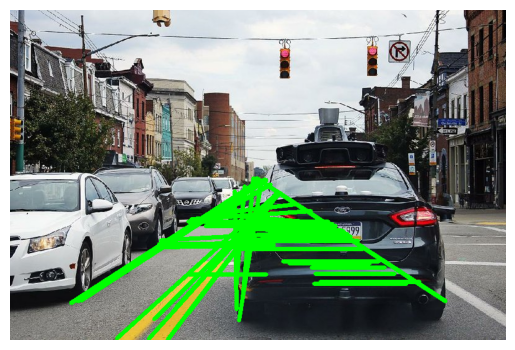

In [ ]:
image_path = "resized_250499-ap16303000894530_73-23048_t800.jpg"  # Replace with your image path
lane_detection_image(image_path)


0: 448x640 4 cars, 3 traffic lights, 53.6ms
Speed: 6.0ms preprocess, 53.6ms inference, 167.2ms postprocess per image at shape (1, 3, 448, 640)


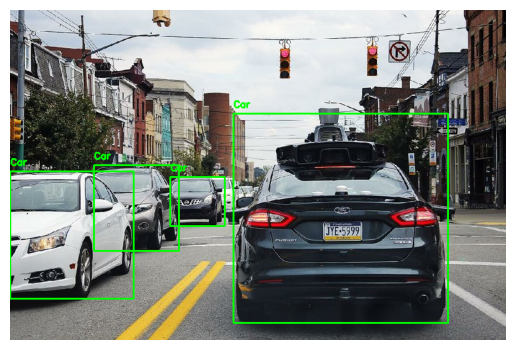

In [ ]:
image_path = "resized_250499-ap16303000894530_73-23048_t800.jpg"  # Replace with your image path
vehicle_detection_image(image_path)

In [ ]:
model = YOLO('yolov8n.pt')  # Use a YOLOv8 model, for example yolov8n.pt

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:


# Load YOLOv8 pre-trained model


# Function to detect cars using YOLOv8
from networkx import draw


def detect_cars(image):
    # Perform detection with YOLOv8 model
    results = model(image)

    # Extract bounding boxes for cars
    bboxes = []
    for result in results[0].boxes:  # Iterate over detections (boxes are part of the result)
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()  # Extract bbox coordinates
        conf = result.conf[0].cpu().numpy()  # Confidence score for the prediction
        class_id = result.cls[0].cpu().numpy()  # Class ID (for 'car' class ID should be 2)

        if class_id == 2 and conf>=0.6:  # Class ID 2 corresponds to 'car'
            bboxes.append([x1, y1, x2, y2, conf])

    return np.array(bboxes)


# Preprocess before passing to YOLO

def detect_plate_with_haar(image):
    plate_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_russian_plate_number.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plates = plate_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in plates:
        plate_region = image[y:y+h, x:x+w]
        return plate_region

    return None  # No plate detected


def detect_lanes(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blurred, 50, 150)

    mask = np.zeros_like(edges)
    height, width = edges.shape
    polygon = np.array([[
        (0, height),
        (width / 2, height / 2),
        (width, height)
    ]], np.int32)
    cv2.fillPoly(mask, polygon, 255)

    masked_edges = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    solid_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)

            # Solid lines are generally longer and have a specific angle
            if length > 110 and 10 < angle < 90:  # Adjust angle range as needed
                solid_lines.append((x1, y1, x2, y2))
    print(solid_lines,"i am line")
    image_with_lines = draw_lines(image.copy(), solid_lines)
    plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return solid_lines

# def detect_lanes(image):
#     """
#     Detect solid white lanes in an image.

#     Parameters:
#         image (ndarray): Input image (BGR format).

#     Returns:
#         list: List of solid lane lines [(x1, y1, x2, y2), ...].
#     """
#     # Convert to grayscale and equalize histogram
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     gray = cv2.equalizeHist(gray)

#     # Apply Gaussian blur to reduce noise
#     blurred = cv2.GaussianBlur(gray, (5, 5), 0)

#     # Adaptive thresholding
#     mean_intensity = np.mean(gray)
#     is_dark_background = mean_intensity < 128
#     thresh = cv2.adaptiveThreshold(
#         blurred, 255,
#         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#         cv2.THRESH_BINARY_INV if is_dark_background else cv2.THRESH_BINARY,
#         11, 2
#     )

#     # Morphological operations to clean noise
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
#     thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

#     # Edge detection
#     edges = cv2.Canny(thresh, 50, 150)
#     print(edges, "i am edges")

#     # Mask the region of interest (e.g., bottom half of the image)
#     height, width = edges.shape
#     mask = np.zeros_like(edges)
#     polygon = np.array([[
#         (0, height * 0.6),
#         (width, height * 0.6),
#         (width, height),
#         (0, height),
#     ]], np.int32)
#     cv2.fillPoly(mask, polygon, 255)
#     edges = cv2.bitwise_and(edges, mask)

#     # Hough Line Transform
#     lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=20)
#     print(lines, "i am lines")
#     # Filter solid lines based on length and angle
#     solid_lines = []
#     if lines is not None:
#         for line in lines:
#             x1, y1, x2, y2 = line[0]
#             length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
#             angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)

#             # Solid lines are generally longer and have a specific angle
#             if length > 200 and 10 < angle < 80:  # Adjust angle range as needed
#                 solid_lines.append((x1, y1, x2, y2))
#     image_with_lines  =draw_lines(image, solid_lines)

#     plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()

#     return solid_lines


# def track_and_crossing(image, car_bboxes, lanes):
#     bboxes = []
#     if lanes is None:
#         return bboxes
#     for bbox in car_bboxes:
#         x1, y1, x2, y2,_ = map(int,bbox)
#         car_center = ((x1 + x2) // 2, (y1 + y2) // 2)

#         for line in lanes:
#             if isinstance(line, (list, np.ndarray)) and len(line) == 1:
#                 x1_line, y1_line, x2_line, y2_line = line[0]
#             else:
#                 x1_line, y1_line, x2_line, y2_line = line
#             if (car_center[1] > y1_line and car_center[1] < y2_line) or( car_center[0] >x1_line and car_center[0]<x2_line):
#                 print(f"Car crossed lane at {car_center}")
#                 bboxes.append(bbox)
#                 cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
#                 cv2.line(image, (x1_line, y1_line), (x2_line, y2_line), (0, 0, 255), 2)

#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()
#     return bboxes
import math

def filter_lanes(lanes):
    """
    Filter detected lanes to remove false positives like zebra crossings.

    Parameters:
        lanes (list): List of lane lines [(x1, y1, x2, y2), ...].

    Returns:
        list: Filtered list of valid lane lines.
    """
    if not lanes or len(lanes) < 4:
        return lanes

    def calculate_angle(x1, y1, x2, y2):
        """Calculate the angle of a line in degrees."""
        return math.degrees(math.atan2(y2 - y1, x2 - x1))

    filtered_lanes = []
    angles = []
    distance_threshold = 50  # Minimum distance between valid lane lines
    angle_threshold = 5  # Maximum angular difference for parallel lines

    # Calculate angles for all lines
    for line in lanes:
        x1, y1, x2, y2 = line
        angle = calculate_angle(x1, y1, x2, y2)
        angles.append((angle, line))

    # Group lines with similar angles
    for i, (angle1, line1) in enumerate(angles):
        parallel_lines = [line1]
        for j, (angle2, line2) in enumerate(angles):
            if i != j and abs(angle1 - angle2) < angle_threshold:
                # Check if lines are relatively far apart
                x1_1, y1_1, x2_1, y2_1 = line1
                x1_2, y1_2, x2_2, y2_2 = line2
                distance = math.sqrt((x1_2 - x1_1)**2 + (y1_2 - y1_1)**2)
                if distance > distance_threshold:
                    parallel_lines.append(line2)

        # Only consider cases with exactly two parallel lines
        if len(parallel_lines) == 2:
            filtered_lanes.extend(parallel_lines)

    # Remove duplicates
    unique_lanes = list({tuple(line) for line in filtered_lanes})

    return [list(line) for line in unique_lanes]

def track_and_crossing(image, car_bboxes, lanes, shrink_factor=0.9):
    """
    Check if car bounding boxes cross detected lanes with adjusted box size.

    Parameters:
        image (ndarray): Input image (BGR format).
        car_bboxes (list): List of car bounding boxes [(x1, y1, x2, y2), ...].
        lanes (list): List of lane lines [(x1, y1, x2, y2), ...].
        shrink_factor (float): Factor to shrink the bounding box (0 < shrink_factor <= 1).

    Returns:
        list: Bounding boxes of cars that crossed lanes.
    """
    lanes = filter_lanes(lanes)  # Filter zebra crossing lines
    bboxes = []
    if lanes is None or len(lanes) == 0:
        return bboxes

    def line_intersects(line1, line2):
        """Check if two line segments (line1 and line2) intersect."""
        def ccw(A, B, C):
            """Helper function to check counter-clockwise order."""
            return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

        A, B = line1
        C, D = line2
        return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

    for bbox in car_bboxes:
        x1, y1, x2, y2, _ = map(int, bbox)

        # Shrink the bounding box
        width = x2 - x1
        height = y2 - y1
        shrink_x = int(width * (1 - shrink_factor) / 2)
        shrink_y = int(height * (1 - shrink_factor) / 2)

        x1_shrink = x1 + shrink_x
        y1_shrink = y1 + shrink_y
        x2_shrink = x2 - shrink_x
        y2_shrink = y2 - shrink_y

        # Represent the shrunken bounding box as four line segments
        car_lines = [
            ((x1_shrink, y1_shrink), (x2_shrink, y1_shrink)),  # Top
            ((x2_shrink, y1_shrink), (x2_shrink, y2_shrink)),  # Right
            ((x2_shrink, y2_shrink), (x1_shrink, y2_shrink)),  # Bottom
            ((x1_shrink, y2_shrink), (x1_shrink, y1_shrink)),  # Left
        ]

        for lane in lanes:
            if isinstance(lane, (list, np.ndarray)) and len(lane) == 1:
                x1_line, y1_line, x2_line, y2_line = lane[0]
            else:
                x1_line, y1_line, x2_line, y2_line = lane

            lane_line = ((x1_line, y1_line), (x2_line, y2_line))

            # Check for intersection with any side of the shrunken bounding box
            if any(line_intersects(car_line, lane_line) for car_line in car_lines):
                print(f"Car crossed lane at bounding box: {bbox}")
                bboxes.append(bbox)
                # Draw the car bounding box and the lane
                cv2.rectangle(image, (x1_shrink, y1_shrink), (x2_shrink, y2_shrink), (255, 0, 0), 2)
                cv2.line(image, (x1_line, y1_line), (x2_line, y2_line), (0, 0, 255), 2)
                break  # No need to check other lanes for this car

    # Display the result
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return bboxes




def extract_number_plate(image, car_bbox= None):
  number_plate = []
  for plate_roi in image:
    plt.imshow(cv2.cvtColor(plate_roi, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(plate_roi)
    # x1, y1, x2, y2,_ = bbox
    # plate_roi = image[int(y1):int(y2), int(x1):int(x2)]
    result = reader.readtext(plate_roi)
    threshold_conf = 0.1
    max_conf = 0
    for detection in result:
        _, text, confidence = detection
        print(confidence, "iam confident")
        if confidence > threshold_conf and confidence > max_conf:
          number_plate.append(text)
  return number_plate

# Load the image and run the detection pipeline

def preprocess_number_plate(image, car_bbox):
    # Crop the number plate area
  processed_plates = []
  hash_map = {}
  for bbox in car_bbox:
    x1, y1, x2, y2 = map(int, bbox[:4])
    if not (x1, y1, x2, y2) in hash_map:
        plate_region = image[y1:y2, x1:x2]
        plate_region = detect_plate_with_haar(plate_region)
        # Convert to grayscale
        # gray = cv2.cvtColor(plate_region, cv2.COLOR_BGR2GRAY)

        # # Histogram Equalization
        # # gray = cv2.equalizeHist(plate_region)

        # # Determine background type
        # mean_intensity = np.mean(gray)
        # is_dark_background = mean_intensity < 128

        # # # Apply adaptive thresholding
        # binary = cv2.adaptiveThreshold(
        #     gray, 255,
        #     cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        #     cv2.THRESH_BINARY_INV if is_dark_background else cv2.THRESH_BINARY,
        #     11, 2
        # )

        # # # Remove noise
        # kernel = np.ones((1, 1), np.uint8)
        # binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

        # sharpening_kernel = np.array([[0, 0, 0],
        #                                [0,  9, 0],
        #                                [0, 0, 0]])
        # processed_plate = cv2.filter2D(binary, -1, sharpening_kernel)
        if plate_region is not None:
            processed_plates.append(plate_region)
            hash_map[(x1, y1, x2, y2)] = 1
  print(processed_plates,len(processed_plates), 'iam plates')
  print(hash_map, "i am hash")
  return processed_plates





0: 448x640 8 cars, 1 truck, 3 traffic lights, 69.0ms
Speed: 7.0ms preprocess, 69.0ms inference, 9.0ms postprocess per image at shape (1, 3, 448, 640)
(3, 5) here at 
[(254, 532, 348, 407), (230, 523, 335, 406)] i am line


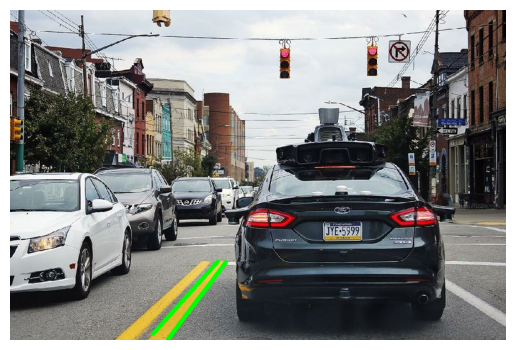

[] 0 iam plates
{} i am hash
Detected Number Plate: []


In [ ]:
image = cv2.imread("resized_250499-ap16303000894530_73-23048_t800.jpg")

car_bboxes = detect_cars(image)
print(car_bboxes.shape, "here at ")
lanes = detect_lanes(image)
# image = preprocess_image(image)
tracked_car = track_and_crossing(image, car_bboxes, lanes)

# Extract number plate for the first detected car
preprocessed_image = preprocess_number_plate(image, tracked_car)
if preprocessed_image is not None:
  number_plate = extract_number_plate(preprocessed_image)
  print(f"Detected Number Plate: {number_plate}")
else:
  print("No number plate detected")
# Show the final image with lanes and car detection
plt.show()